# TP Optimisation II:  A simple neural network 

### Nom(s): BELMAKHFI
### Prénom(s): Nihal
### Groupe: B1

## Useful packages

In [2]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## Loading of the train and test data

In [3]:
#
# Load train data
#
Xtrain = np.load('train-images.npy')
Xtrain = np.array([x.ravel()/255 for x in Xtrain])
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
Ytrain = np.load('train-labels.npy')
targets_train = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytrain:
    v      = np.zeros((10,1))
    v[lab] = 1
    targets_train+=[np.array(v)]

#
# Load test data
#
Xtest        = np.load('t10k-images.npy')
Xtest        = np.array([x.ravel()/255 for x in Xtest])
Xtest        = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)
Ytest        = np.load('t10k-labels.npy')
targets_test = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytest:
    v = np.zeros((10,1))
    v[lab]=1
    targets_test+=[np.array(v)]
#
# Outputs
#
print('There are ',Xtrain.shape[0],'images in the train set')
print('There are ',Xtest.shape[0],'images in the test set')

There are  60000 images in the train set
There are  10000 images in the test set


## Definition of the activation function

 The activation function defines the output of a node given a set of inputs. We use the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> function defined by
 
 $$\sigma_{\alpha} : \mathbb{R}^p\rightarrow [0,1]^p, \quad \mbox{ s.t.} \quad[\sigma_{\alpha}(x)]_i=\frac{e^{x_i+\alpha_i}}{\displaystyle{\sum_{j=1}^{p}e^{x_j+\alpha_j}}}\quad \forall i=1:p. $$  


In [4]:
#
# Nonlinear activation function
#
def softmax(x,alpha):
    """
    Softmax unit activation function 
    x    : Numpy array
    alpha: scalar
    """ 
    taille = len(x)
    value = np.zeros((taille,1)) #pour créer un tableau numpy de "taille" lignes et 1 colonne
    value = np.exp(x+alpha)/np.sum(np.exp(x+alpha))
    
    return value

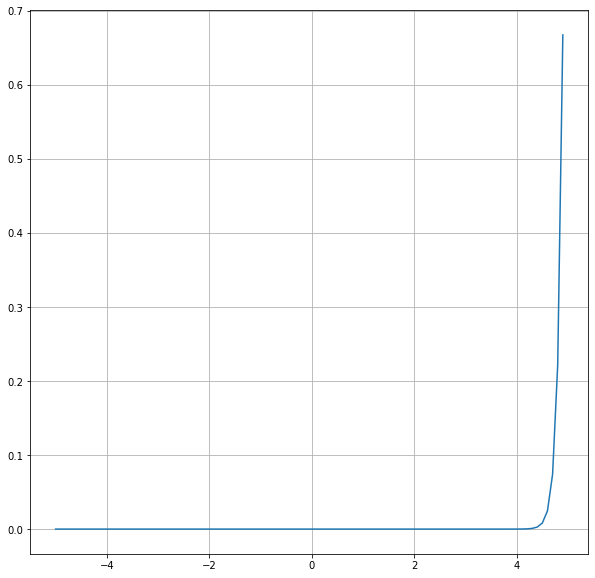

In [5]:
#
# Example of a plot of the activation function
#
t     = np.arange(-5,5,0.1)
alpha = np.arange(-50,50,1)
plt.figure(figsize=(10,10))
plt.plot(t,softmax(t,alpha))
plt.grid(True)
plt.show()

## Definition of a simple neural network

We use a one-layer fully-connected neural network with the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> activation function.


In [6]:
def NN(x,W):
    """
    # One-layer fully connected neural network
    # x: image, i.e. 784x1 vector (28x28)
    # W: weight matrices of shape 10x784   
    """
    taille = np.size(W[:,0]) #nombre d'éléments dans la première colonne de W
    pred = softmax(W@x, np.zeros((taille,1)))
    
    return pred

## Definition of the loss function

The loss function is the <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross-entropy</a> defined by 

$$J(W)=-\sum_{i=1}^N p_i \log(q_i(W)),$$ where $N$ is the number of classes, $(p_i)_{i=1:N}$ are the probabilities of  a data from the training set to belong to a class (0 or 1 because the labels are known), and $(q_i(W))_{i=1:N}$ are the predicted probabilities from the model

$$\forall i=1:N, \quad q_i(W)=[\sigma_{\alpha}(Wx)]_i.$$

In [7]:
#
# Loss function = Cross-entropy
#
def cross_entropy(pred,target,x):
    """
    pred:   predicted probabilities (q(W))
    target: probabilities (p)
    x:      image 
    """ 
    #ce: Cross-entropy
    ce = - np.sum(np.transpose(target)@np.log(pred))
    
    # gradient of the cross-entropy
    s = pred
    u    =  np.ones((s.shape[0],1))
    g    = (-u.T.dot(target)*(s.dot(x.T))+target*x.T)
    grad = -g.reshape(x.shape[0]*target.shape[0],1)
    
    return ce,grad
#
# Main function 
#
def f(W,x,target):
    """
    W:      weights
    target: probabilities (p)
    x:      image
    """
    #pred
    pred = NN(x,W)
    #ce, grad
    ce, grad = cross_entropy(pred,target,x)
    
    return ce,grad,pred

In [8]:
#
# Test information on the gradient with calls of f
#

# Define weight matrices
W      = np.random.rand(10,Xtrain.shape[1])
eps    = 1e-8
d      = np.random.rand(10,Xtrain.shape[1])
Wtilde = W+eps*d

# Retrieve the information on the gradients
res    = (f(Wtilde,Xtrain[0],targets_train[0])[0]-f(W,Xtrain[0],targets_train[0])[0])/eps
print(res)

g      = f(W,Xtrain[0],targets_train[0])[1]
print(g.T.dot(d.reshape(7840,1)))

-7.388465572688574
[[-7.38846742]]


## Generating batches 

In [9]:
#
# Function to create batches of samples to be used later in the training phase
#
def create_batches(x,bs):
    """
    x : set to be considered (array)
    bs: batch size (scalar)
    """
    batches = []
    ind     = np.arange(x.shape[0])
    random.shuffle(ind)
    nbatch  = ind.shape[0]//bs
    rest    = ind.shape[0]%bs
    
    for n in range(nbatch):
        batches +=[ind[bs*n:bs*(n+1)]]
    
    # Put the remaining elements in a last batch
    if rest !=0:        
        batches += [ind[-rest:]]
        
    return batches

## Training of the neural network

In [10]:
history    = {}
eta        = 1e-5 # learning rate
momentum   = 0.   # momemtum factor
N_EPOCHS   = 10  
BatchSizes = [10000,1024,256] # try different batch sizes for the analysis

for bs in BatchSizes:
    #
    # Sensitivity to the batch size to be investigated in the analysis
    #
    print('batch size=',bs)
    
    history[bs]={'train loss':[],'train acc':[],'test loss':[0], 'test acc':[0]}
    
    # Initialization of the weights
    w = np.random.rand(10,Xtrain.shape[1])
    
    for n in range(N_EPOCHS):
        # Minimization of the loss function
        
        Batches=create_batches(Xtrain,bs)
        
        for batch in Batches:
            # Loop on the batches
            somme_grad = 0
            somme_ce = 0
            train_acc = 0
            for i in batch:
                
                #on effectue une itération sur les batches de données, où x est le vectuer d'entrée 
                #pour le batch et target est le vecteur de sotie et où on calcule la fonction f pour 
                #le meme batch en question, ensuite on est censé mettre à jour somme_grad, somme_ce, train_acc et w
                x = Xtrain[i]
                target = targets_train[i]
                ce, grad, pred = f(w,x,target)
                somme_grad += grad
                somme_ce +=ce   
                   
            #calculer la précision du modèle sur les données de test
            # Initialisation de la précision à 0
            test_acc = 0

            # Pour chaque donnée de test
            for i, x in enumerate(Xtest):
                lab = targets_test[i]  # La vraie classe est extraite de targets_test
                ce, _, pred = f(w, x, lab)   # On calcule la prédiction pour l'entrée x
                prediction = np.argmax(pred) # On trouve l'indice de la classe prédite
                true = np.argmax(lab)        # On trouve l'indice de la vraie classe
                if prediction == true:       # Si la prédiction est correcte
                    test_acc += 1            # La précision est mise à jour

            # La précision est divisée par le nombre total de données de test pour obtenir la précision moyenne
            # test_acc /= Xtest.shape[0]

            #On met à jour l'historique d'enchainement avec la précision de la perte calculée
            #bs est la taille du batch actuel
            history[bs]['train acc'] += [train_acc/batch.shape[0]]
            history[bs]['train loss'] += [somme_ce/batch.shape[0]]
            
            #On met en forme les gradients calculés pour correspondre à la taille de la matrice de poids w
            somme_grad = somme_grad.reshape(w.shape[0],w.shape[1])
            
            #On utilise la formule standard de descente de gradient stochastique, eta = taux d'apprentissage
            w = w-eta*somme_grad
        
                
                
                
                
        
        # Test accuracy at the end of each epoch  
        # Effectuons un test de précision sur les données de test en utilisant w
        ce_test = 0
        for i, x in enumerate(Xtest):
            targets_test_i = targets_test[i]
            ce,_,pred = f(w,x,targets_test_i)
            #ce_test est la somme de toutes les fonctions d'erreur
            ce_test += ce
                
        #calculer la précision du modèle sur les données de test
        # Initialisation de la précision à 0
        test_acc = 0

        # Pour chaque donnée de test
        for i, x in enumerate(Xtest):
            lab = targets_test[i]  # La vraie classe est extraite de targets_test
            ce, _, pred = f(w, x, lab)   # On calcule la prédiction pour l'entrée x
            prediction = np.argmax(pred) # On trouve l'indice de la classe prédite
            true = np.argmax(lab)        # On trouve l'indice de la vraie classe
            if prediction == true:       # Si la prédiction est correcte
                test_acc += 1            # La précision est mise à jour

        # La précision est divisée par le nombre total de données de test pour obtenir la précision moyenne
        # test_acc /= Xtest.shape[0]

        history[bs]['test acc'] += [test_acc/Xtest.shape[0]]
        history[bs]['test loss'] += [ce_test/Xtest.shape[0]]
     
        print('Epoch number :', n+1,'test accuracy:',history[bs]['test acc'][n+1],'test loss',history[bs]['test loss'][n+1])
        

    print('\n')            

batch size= 10000
Epoch number : 1 test accuracy: 0.2048 test loss 3.0235929390425325
Epoch number : 2 test accuracy: 0.2734 test loss 2.512321016757168
Epoch number : 3 test accuracy: 0.3495 test loss 2.1339300813121453
Epoch number : 4 test accuracy: 0.4242 test loss 1.8514887459750908
Epoch number : 5 test accuracy: 0.4801 test loss 1.6389399203457302
Epoch number : 6 test accuracy: 0.527 test loss 1.4759255464005827
Epoch number : 7 test accuracy: 0.5682 test loss 1.3486444043073589
Epoch number : 8 test accuracy: 0.5986 test loss 1.2467785264487108
Epoch number : 9 test accuracy: 0.6204 test loss 1.1639355423869162
Epoch number : 10 test accuracy: 0.6405 test loss 1.0954763176439464


batch size= 1024
Epoch number : 1 test accuracy: 0.1855 test loss 2.958286562814833
Epoch number : 2 test accuracy: 0.2844 test loss 2.3472945850285365
Epoch number : 3 test accuracy: 0.3777 test loss 1.9902475031701332
Epoch number : 4 test accuracy: 0.4499 test loss 1.7353036883208894
Epoch number 

## Plots of the evolution of the loss function

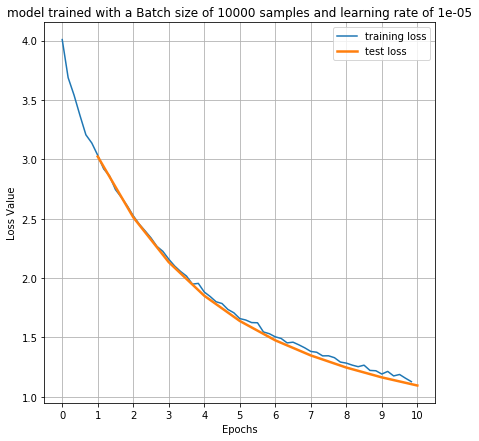

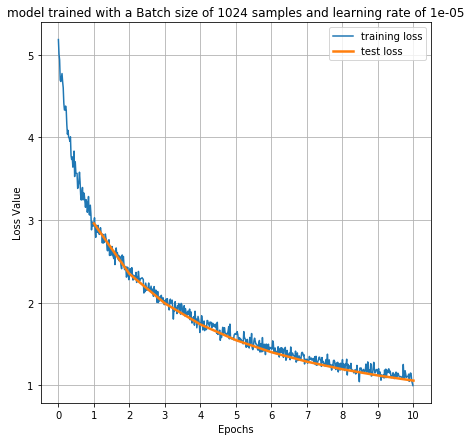

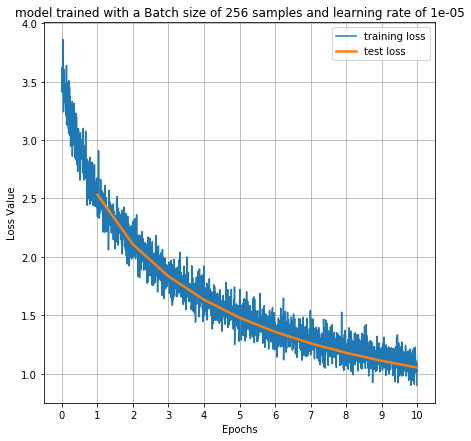

In [12]:
for bs in BatchSizes:
       
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    E  = [n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train loss'],label = 'training loss')
    plt.plot(E[1:],history[bs]['test loss'][1:],linewidth=2.5,label = 'test loss')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    #plt.ylim([0,np.max(history[bs]['test loss'])+2])
    plt.grid(True)
    plt.legend()
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.show()

## Plots of the evolution of the accuracy

In [ ]:
for bs in BatchSizes:
    print(bs)   
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    print(n_batch)
    E=[n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train acc'] ,label  = 'training acuracy')
    plt.plot(E[1:],history[bs]['test acc'][1:],linewidth=2.5,label = 'test acuracy')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.ylim([0,1])
    plt.legend()
    
    plt.show()

## Analysis of the results

Please provide your comments on the sensitivity of the results to the parameters involved in the learning process (batch size, learning rate, momentum).

### Your comments:

#### Inflence of the batch size (eta (learning rate) = 1e-5 , momemtum (momemtum factor) = 0.)
Le batch size correspond à la taille des lots (training) de données utilisées pour former le modèle. 
En général, on observe que plus la taille des lots est petite, meilleure est la précision du modèle. 
Dans ce code, on compare la performance du modèle pour trois tailles de lots différentes (10000, 1024 et 256). Les résultats montrent que la taille de lot la plus petite (256) donne les meilleurs résultats en termes de perte et de précision. Cependant, il est important de noter que l'augmentation de la taille des lots entraîne une convergence plus rapide du modèle pendant l'entraînement. 
Les courbes de précision et de perte en fonction de l'epoch montrent que lorsque la taille des lots est plus petite, les courbes de formation (training) oscillent davantage autour des valeurs de test. Cela peut être dû à un bruit plus important dans les données d'apprentissage lorsqu'on utilise des lots plus petits.

#### Inflence of the learning rate (batch size = [1000, 1024, 256] , momemtum (momemtum factor) = 0.)
Le taux d'apprentissage (learning rate) est un paramètre important qui influe sur les valeurs des poids du modèle. Un taux d'apprentissage faible (par exemple, eta = 1e-10) limite l'évolution du modèle et produit des résultats peu satisfaisants en termes de précision et de perte.
En effet, pour cette valeur de eta avec 10 epochs, on observe que la précision est très faible et la perte très élevée. Les graphiques montrent que les valeurs de training varient considérablement autour de la valeur de test, mais il y a très peu d'amélioration de la précision ou de diminution de la perte sur les valeurs de test.
En revanche, pour un taux d'apprentissage plus élevé (par exemple, eta = 1e-5), on observe une augmentation progressive de la précision et une diminution de la perte pour toutes les tailles de batch, ce qui se traduit par des courbes qui évoluent progressivement en fonction de l'epoch. Les résultats sont nettement meilleurs que pour un taux faible.
Pour un taux d'apprentissage encore plus élevé (par exemple, eta = 1e-3), on obtient une précision très élevée et une perte très faible. Les graphiques montrent une croissance très rapide au début de la courbe, suivie d'une stabilisation autour d'une valeur presque constante pour les tailles de batch inférieures. En revanche, pour un batch size de 1000, les courbes de test sont moins stables et les valeurs de précision et de perte n'évoluent pas de manière continue vers une valeur presque constante comme pour les autres tailles de lots.